In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import xarray as xa
from pprint import pprint

fdir = "/home/jungyoung/Project_win/hh_neuralnet/"

import sys
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal

import hhclustering as hc
import utils 
import scipy

from importlib import reload
reload(utils)

from tqdm.notebook import tqdm, trange
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
from numba import njit

# Load data

In [11]:
# Load dataset
tag = ""
feature_dims = (15, 15, 3, 16)
fdir = "../three_pop_mpi/simulation_data/data/" # raw
fdir_repr = "../gen_three_pop_samples_repr/data/"
fname_post = "../three_pop_mpi/simulation_data/post_inv.nc"
fname_align = "./data/align_data_sub%s.pkl"%(tag)
fname_cluster = "./data/cluster_id_sub%s.nc"%(tag)
fname_repr = "./data/cluster_repr_points%s.pkl"%(tag)

# load raw data
summary_obj = hhtools.SummaryLoader(fdir, load_only_control=True)
repr_obj = hhtools.SummaryLoader(fdir_repr, load_only_control=True)

# load postdata
postdata = xa.open_dataarray(fname_post)

with open(fname_align, 'rb') as fp:
    align_data_sub = pkl.load(fp)
    
data = align_data_sub["data"].copy()
echelon = np.array([c["rank"] for c in align_data_sub["col_names"]])

clusters = xa.load_dataset(fname_cluster)
cluster_id = clusters.cluster_id.data.flatten().copy()

with open(fname_repr, 'rb') as fp:
    repr_info = pkl.load(fp)

# min-max normalize
svals = clusters.sval.data.flatten().copy()
# svals[svals < 0] = 0
svals = (svals - svals.min())/(svals.max() - svals.min())

def get_flat_id(idx):
    flat_id = 0
    multi = 1
    for n in np.arange(len(feature_dims))[::-1]:
        assert feature_dims[n] > idx[n]
        flat_id += idx[n] * multi
        multi *= feature_dims[n]
    return flat_id

def get_square_id(flat_id):
    idx = []
    
    div = 1
    for d in feature_dims[1:]:
        div *= d
    assert flat_id < div * feature_dims[0]
    
    for n in range(len(feature_dims)-1):
        idx.append(flat_id//div)
        if idx[-1] < 0: idx[-1] = 0
        flat_id -= idx[-1] * div
        div = div // feature_dims[n+1]
    idx.append(flat_id)
    
    return idx

# Show the clustering result on the 2D plane

In [3]:
import umap

umap_obj = umap.UMAP(random_state=42, n_neighbors=200, n_components=2, metric="euclidean", min_dist=0.8)
umap_obj.fit(data.T)

/home/jungyoung/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.8, n_jobs=1, n_neighbors=200, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

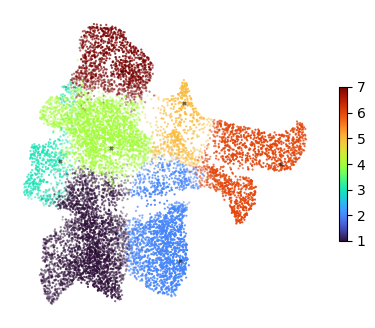

In [4]:
data_umap = umap_obj.transform(data.T)

plt.figure(figsize=(5, 4))
plt.scatter(data_umap[:, 0], data_umap[:, 1], s=10, c=cluster_id, alpha=svals, cmap="turbo",
           marker=".", edgecolor="none", vmax=7, vmin=1)

# ct = np.arange(2/7, 5, 4/7)
# plt.colorbar(shrink=0.8, ticks=np.arange(6/10, 7, 7/10))
# plt.colorbar(ticks=np.arange(1/2, 7, 1/2))
plt.colorbar(shrink=0.5, ticks=np.arange(1, 10))
# plt.xticks()

for nc in range(int(repr_info["cluster_id"].max())):
    l = repr_info["repr_idx"][nc]
    flat_id = get_flat_id(l)
    # plt.scatter(data_umap[flat_id,0], data_umap[flat_id,1], c='k', edgecolor='w', linewidths=1, marker="x")
    plt.scatter(data_umap[flat_id, 0], data_umap[flat_id, 1], marker="x", c='k', alpha=0.5, s=5)

plt.axis("off")
# plt.savefig("./figs/clustering_embedding/umap_cluster%s.png"%(tag))
plt.show()

## Check dynamics

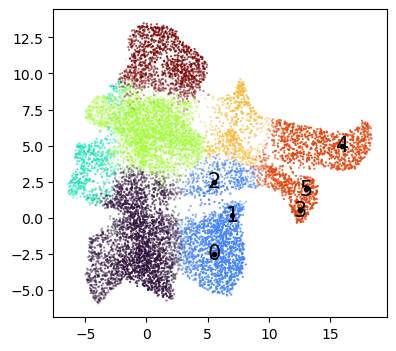

In [5]:
pts = [[5.5, -2.5],
       [  7,  0.2],
       [5.5,  2.5],
       [12.5, 0.5],
       [16, 5],
       [13, 2]]
pts = np.array(pts)

plt.figure(figsize=(4.3, 4))
plt.scatter(data_umap[:, 0], data_umap[:, 1], s=10, c=cluster_id, alpha=svals, edgecolor="none", cmap="turbo",
           marker=".")

locs = []
for n in range(len(pts)):
    plt.scatter(pts[n][0], pts[n][1], color='k', marker=".")
    plt.text(pts[n][0], pts[n][1], "%d"%(n), fontsize=15, va="center", ha="center")
    
    d = np.sqrt(((data_umap - pts[n][None,:])**2).sum(axis=1))
    nmin = np.argmin(d)
    locs.append(get_square_id(nmin))

plt.show()

In [290]:
def get_sample_psd(loc, nt):
    detail = summary_obj.load_detail(*loc, nt)
    t = detail["ts"]
    
    # compute_psd_set
    psd_set = []
    for ntp in range(1, 3):
        v = detail["vlfp"][ntp]
        psd, fpsd, tpsd = hhsignal.get_stfft(v, t, 2000, frange=(5, 100))
        idt = (tpsd >= 0.5)
        psd_set.append(psd[:, idt])
        
    return np.array(psd_set), fpsd, tpsd


def get_sample_psd_repr(cid, nt=0):
    detail = repr_obj.load_detail(cid-1, nt)
    # detail = summary_obj.load_detail(*loc, nt)
    t = detail["ts"]
    
    # compute_psd_set
    psd_set = []
    for ntp in range(1, 3):
        v = detail["vlfp"][ntp]
        psd, fpsd, tpsd = hhsignal.get_stfft(v, t, 2000, frange=(5, 100))
        idt = (tpsd >= 0.5)
        psd_set.append(psd[:, idt])
        
    return np.array(psd_set), fpsd, tpsd

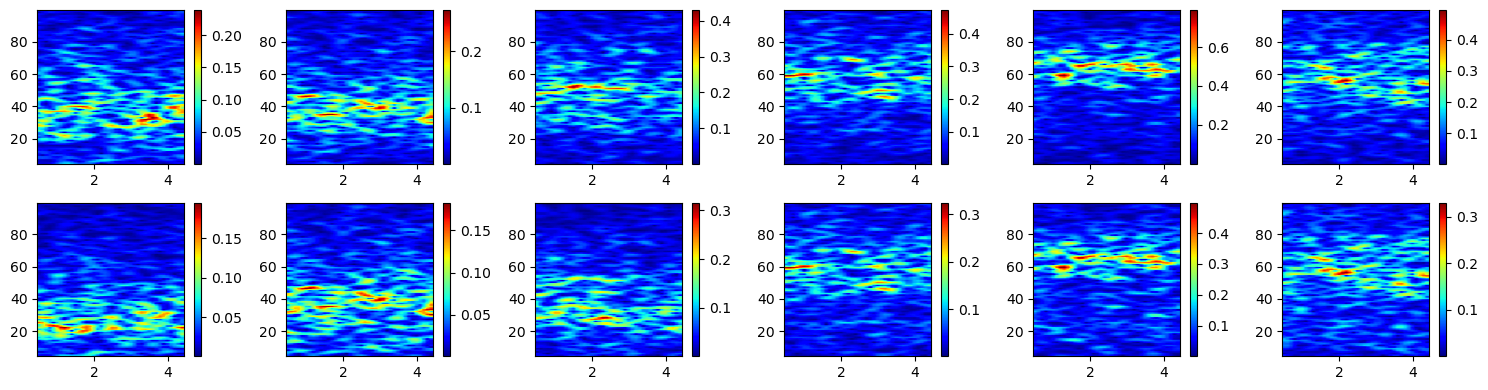

In [396]:
# get psd
N = len(locs)
psd_set = []
for n in range(len(locs)):
    psd_set.append(get_sample_psd(locs[n], 0))
    
#     detail = summary_obj.load_detail(*locs[n], 0)
#     t = detail["ts"]
    
#     # compute_psd_set
#     psd_set.append([])
#     for ntp in range(1, 3):
#         v = detail["vlfp"][ntp]
#         psd, fpsd, tpsd = hhsignal.get_stfft(v, t, 2000, frange=(5, 100))
#         idt = (tpsd >= 0.5)
#         psd = psd[:,idt]
#         # psd = (psd - psd.mean(axis=1, keepdims=True))/psd.std(axis=1, keepdims=True)
#         psd_set[-1].append(psd[:, idt])
        
tpsd = tpsd[idt]

fig, axs = plt.subplots(2, N, figsize=(2.5*N, 4), dpi=100)
for n in range(N):
    for i in range(2):
        plt.sca(axs[i][n])
        hhtools.imshow_xy(psd_set[n][i], x=tpsd, y=fpsd, cmap="jet")
        plt.colorbar()
        
plt.tight_layout()
plt.show()

## Show cluster features

In [43]:
def print_params(locs):
    keys = ("alpha", "beta", "rank", "w")
    params = []
    for l, k in zip(locs, keys):
        # print(l, k)
        x = postdata.coords[k][l].data
        params.append(x)
        print("%s: %f"%(k, x))
        
    return params

In [107]:
target_cid = 7
features = align_data_sub["data"][:, cluster_id==target_cid]
svals_target = svals[cluster_id==target_cid]
svals_target[svals_target < 0] = 0

l = repr_info["repr_idx"][target_cid-1]
n0 = get_flat_id(l)
# psd_set, fpsd, tpsd = get_sample_psd(l, 0)
psd_set, fpsd, tpsd = get_sample_psd_repr(target_cid)

params = print_params(l)

nr = l[2]
idx = np.arange(feature_dims[-1]*nr, feature_dims[-1]*(nr+1))
feature_base = align_data_sub["data"][:, idx].mean(axis=1)

alpha: 0.571429
beta: 0.142857
rank: 1.000000
w: 0.150000


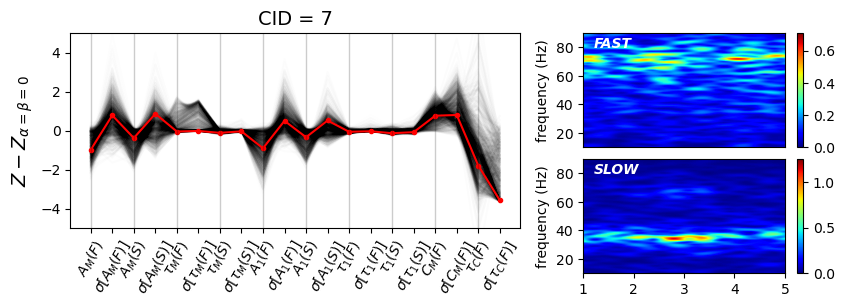

In [108]:
xl = (1, 5)

plt.figure(figsize=(9, 3))

plt.axes((0.1, 0.25, 0.5, 0.65))

for n in range(features.shape[1]):
    plt.plot(features[:,n]-feature_base, color='k', alpha=svals_target[n]*0.02)
plt.plot(align_data_sub["data"][:,n0]-feature_base, "r.-", alpha=1)
r = align_data_sub["row_labels"]
plt.xticks(np.arange(len(r)), labels=r, rotation=60)
plt.ylabel(r"$Z - Z_{\alpha=\beta=0}$", fontsize=14) 

for n in np.arange(0, features.shape[0], 2):
    plt.vlines(n, -10, 10, color="k", lw=1, alpha=0.2)
plt.ylim([-5, 5])
plt.title("CID = %d"%(target_cid), fontsize=14)

plt.axes((0.67, 0.1, 0.28, 0.38))
hhtools.imshow_xy(psd_set[1], x=tpsd, y=fpsd, cmap="jet", vmin=0, interpolation="bicubic", vmax=None)
plt.ylabel("frequency (Hz)", fontsize=10)
plt.xlim(xl)
plt.ylim([10, 90])
plt.text(xl[0]+.2, 80, "SLOW", style="italic", color="w", fontweight="bold")
plt.colorbar()

plt.axes((0.67, 0.52, 0.28, 0.38))
hhtools.imshow_xy(psd_set[0], x=tpsd, y=fpsd, cmap="jet", vmin=0, interpolation="bicubic", vmax=None)
plt.ylabel("frequency (Hz)", fontsize=10)
plt.text(xl[0]+.2, 80, "FAST", style="italic", color="w", fontweight="bold")
plt.xlim(xl)
plt.ylim([10, 90])
plt.colorbar()
plt.xticks([])

fname = "./figs/figs_tmp/clustering_result/sample_%d.png"%(target_cid)
plt.savefig(fname, bbox_inches="tight", dpi=200)
    
plt.show()

In [328]:
od

NameError: name 'od' is not defined

In [326]:
psd_set, fpsd, tpsd = get_sample_psd_repr(4, nt=100)

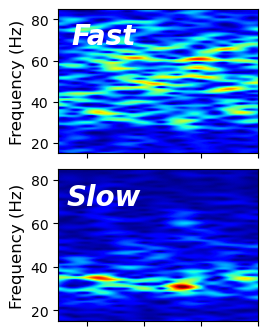

In [327]:
tl = (0.5, 4)

plt.figure(figsize=(2.5, 4))
axs = [plt.axes(position=(0.1, 0.52, 0.8, 0.36)),
       plt.axes(position=(0.1, 0.1, 0.8, 0.38))]
tp_labels = ("Fast", "Slow")

for n in range(2):
    plt.sca(axs[n])
    hhtools.imshow_xy(psd_set[n], x=tpsd, y=fpsd, cmap="jet", vmin=0, interpolation="spline16", vmax=None)
    plt.xlim(tl)
    axs[n].set_xticklabels([])
    plt.yticks(np.arange(20, 90, 20))
    plt.ylim([15, 85])
    plt.ylabel("Frequency (Hz)", fontsize=12)
    plt.text(tl[0]+0.8, 72, tp_labels[n], fontsize=20, va="center", ha="center", color="w", fontweight="bold", fontstyle="italic")


# hhtools.imshow_xy(psd_set[1], x=tpsd, y=fpsd, cmap="jet", vmin=0, interpolation="spline16", vmax=None)
# plt.xlim(tl)

plt.show()

In [293]:
psd_set, fpsd, tpsd = get_sample_psd_repr(5, nt=2)

In [ ]:
tl = (0.5, 4)

plt.figure(figsize=(3, 4))
axs = [plt.axes(position=(0.1, 0.52, 0.8, 0.36)),
       plt.axes(position=(0.1, 0.1, 0.8, 0.38))]
tp_labels = ("Fast", "Slow")

vmax_set = (0.8, 0.4)

for n in range(2):
    plt.sca(axs[n])
    hhtools.imshow_xy(psd_set[n], x=tpsd, y=fpsd, cmap="jet", vmin=0, interpolation="spline16", vmax=vmax_set[n])
    plt.xlim(tl)
    axs[n].set_xticklabels([])
    plt.yticks(np.arange(20, 90, 20))
    plt.ylim([15, 85])
    plt.ylabel("Frequency (Hz)", fontsize=12)
    plt.text(tl[0]+0.8, 72, tp_labels[n], fontsize=20, va="center", ha="center", color="w", fontweight="bold", fontstyle="italic")


plt.show()

In [ ]:
postdata.coords["w"][4]

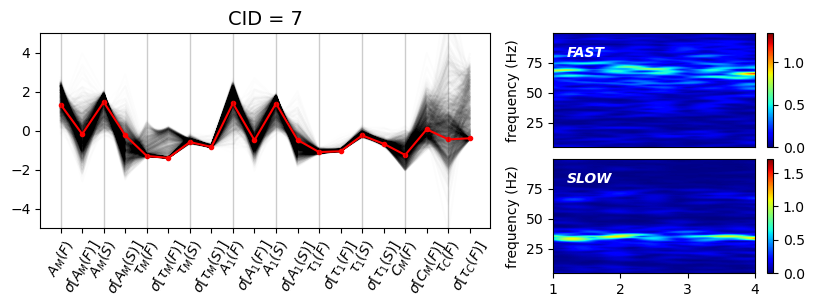

In [166]:
xl = (1, 4)
psd_set, fpsd, tpsd = get_sample_psd([0,0,2,0], 0)
plt.figure(figsize=(9, 3))

plt.axes((0.1, 0.25, 0.5, 0.65))
for n in range(features.shape[1]):
    plt.plot(features[:,n], color='k', alpha=svals_target[n]*0.02)
plt.plot(align_data_sub["data"][:,n0], "r.-", alpha=1)
r = align_data_sub["row_labels"]
plt.xticks(np.arange(len(r)), labels=r, rotation=60)

for n in np.arange(0, features.shape[0], 2):
    plt.vlines(n, -10, 10, color="k", lw=1, alpha=0.2)
plt.ylim([-5, 5])
plt.title("CID = %d"%(target_cid), fontsize=14)

plt.axes((0.67, 0.1, 0.28, 0.38))
hhtools.imshow_xy(psd_set[1], x=tpsd, y=fpsd, cmap="jet", vmin=0, interpolation="bicubic")
plt.ylabel("frequency (Hz)", fontsize=10)
plt.xlim(xl)
plt.text(xl[0]+.2, 80, "SLOW", style="italic", color="w", fontweight="bold")
plt.colorbar()

plt.axes((0.67, 0.52, 0.28, 0.38))
hhtools.imshow_xy(psd_set[0], x=tpsd, y=fpsd, cmap="jet", vmin=0, interpolation="bicubic")
plt.ylabel("frequency (Hz)", fontsize=10)
plt.text(xl[0]+.2, 80, "FAST", style="italic", color="w", fontweight="bold")
plt.xlim(xl)
plt.colorbar()
plt.xticks([])

# fname = "./figs/figs_tmp/clustering_result/sample_%d.png"%(target_cid)
# plt.savefig(fname, bbox_inches="tight", dpi=200)
    
plt.show()

## Draw values on the 2D plane

In [35]:
postdata.coords["key"]

<xarray.DataArray 'key' (key: 16)>
array(['chi', 'cv', 'frs_m', 'ac2p_large', 'fp_large', 'ac2p_1st', 'fp_1st',
       'pwr_large_ft', 'fp_large_ft', 'pwr_1st_ft', 'fp_1st_ft', 'cc1p',
       'tlag_cc', 'leading_ratio', 'leading_ratio(abs)', 'dphi'], dtype=object)
Coordinates:
  * key      (key) object 'chi' 'cv' 'frs_m' ... 'leading_ratio(abs)' 'dphi'

In [129]:
keys = ({"key": "ac2p_large", "pop": "F", "type": "mean"},
        {"key": "ac2p_large", "pop": "F", "type": "var"},
        {"key": "ac2p_large", "pop": "S", "type": "mean"},
        {"key": "ac2p_large", "pop": "S", "type": "var"},
        {"key": "fp_large",   "pop": "F", "type": "mean"},
        {"key": "fp_large",   "pop": "F", "type": "var"},
        {"key": "fp_large",   "pop": "S", "type": "mean"},
        {"key": "fp_large",   "pop": "S", "type": "var"},
        {"key": "ac2p_1st",   "pop": "F", "type": "mean"},
        {"key": "ac2p_1st",   "pop": "F", "type": "var"},
        {"key": "ac2p_1st",   "pop": "S", "type": "mean"},
        {"key": "ac2p_1st",   "pop": "S", "type": "var"},
        {"key": "fp_1st",     "pop": "F", "type": "mean"},
        {"key": "fp_1st",     "pop": "F", "type": "var"},
        {"key": "fp_1st",     "pop": "S", "type": "mean"},
        {"key": "fp_1st",     "pop": "S", "type": "var"},
        {"key": "cc1p",       "pop": "F", "type": "mean"},
        {"key": "cc1p",       "pop": "F", "type": "var"},
        {"key": "tlag_cc",    "pop": "F", "type": "mean"},
        {"key": "tlag_cc",    "pop": "F", "type": "var"}
        # {"key": "leading_ratio",    "pop": "F", "type": "var"},
        # {"key": "leading_ratio(abs)",    "pop": "F", "type": "var"},
       )


row_labels = []
for s in align_data_sub["row_labels"]:
    if "\\tau" in s and "C" not in s:
        s = s.replace("\\tau", "f")
    row_labels.append(s)

print(len(keys), len(align_data_sub["row_names"]))

20 20


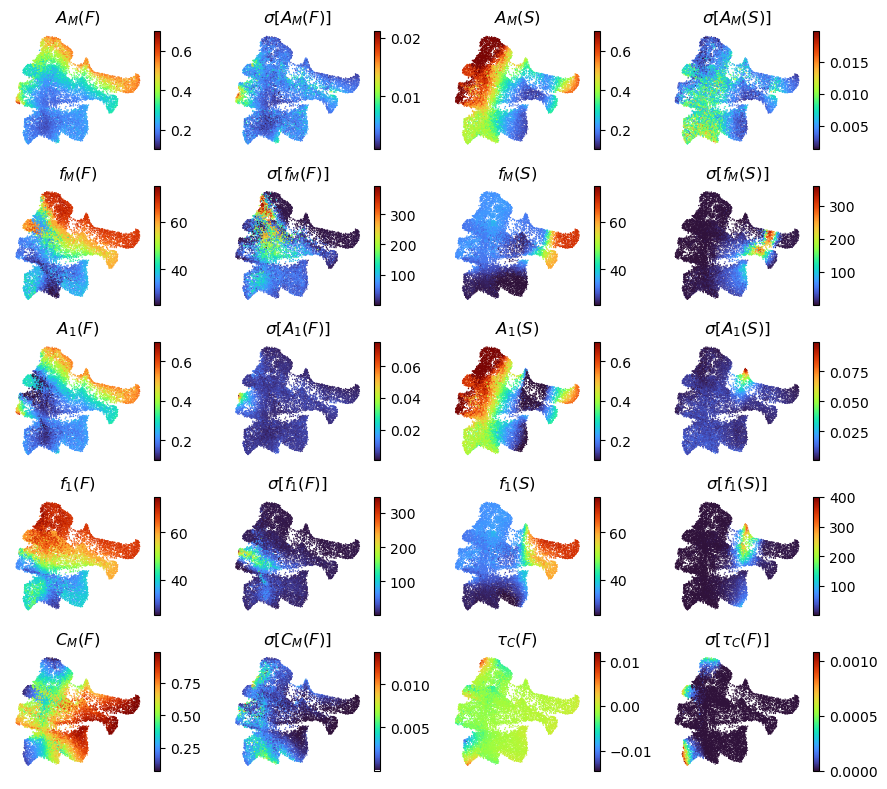

In [140]:
fig, axs = plt.subplots(5, 4, figsize=(9, 8))
for n in range(len(keys)):
    data_sub = postdata.sel(keys[n])
    
    if "$A" in row_labels[n]:
        vmin, vmax = 0.1, 0.7
    elif "$f_" in row_labels[n]:
        vmin, vmax = 25, 75
    else:
        vmin, vmax = None, None
    
    nr = n // 4
    nc = n - 4*nr
    plt.sca(axs[nr][nc])
    plt.scatter(data_umap[:, 0], data_umap[:, 1], s=1, c=data_sub, alpha=1, edgecolor="none", cmap="turbo",
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis("off")
    plt.title(row_labels[n], fontsize=12)
    
plt.tight_layout()
plt.show()

In [145]:
row_labels[::2]

['$A_{M}(F)$',
 '$A_{M}(S)$',
 '$f_{M}(F)$',
 '$f_{M}(S)$',
 '$A_1(F)$',
 '$A_1(S)$',
 '$f_{1}(F)$',
 '$f_{1}(S)$',
 '$C_{M}(F)$',
 '$\\tau_{C}(F)$']

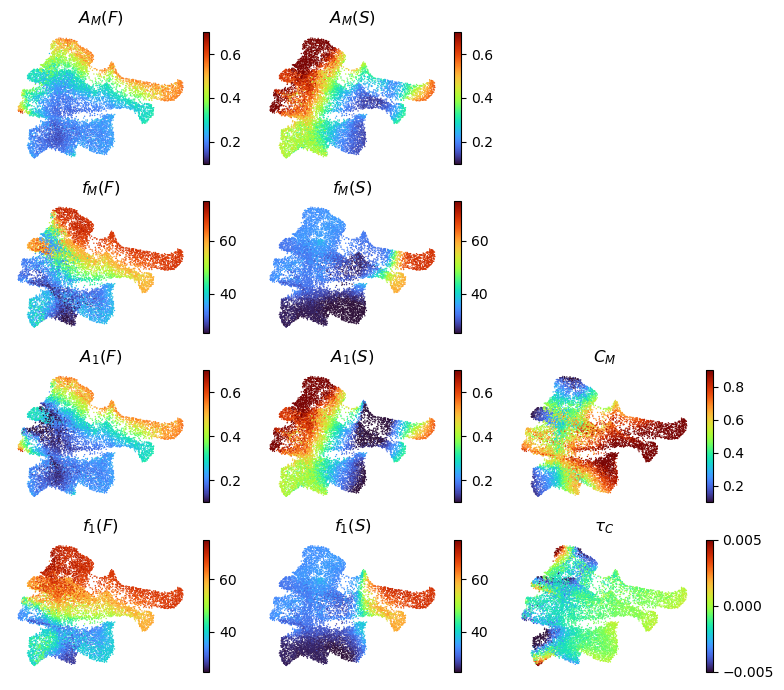

In [160]:
row_labels_sub = row_labels[::2]
fig, axs = plt.subplots(4, 3, figsize=(8, 7))
for n in range(len(row_labels_sub)):
    
    lb = row_labels[2*n]
    if "$A" in lb:
        vmin, vmax = 0.1, 0.7
    elif "$f_" in row_labels[2*n]:
        vmin, vmax = 25, 75
    elif "$C" in row_labels[2*n]:
        vmin, vmax = 0.1, 0.9
        lb = "$C_{M}$"
    else:
        vmin, vmax = -0.005, 0.005
        lb = "$\\tau_{C}$"
    
    data_sub = postdata.sel(keys[2*n])
    
    if n < 8:
        nr = n // 2
        nc = n % 2
    else:
        nr = n - 6
        nc = 2
    
    plt.sca(axs[nr][nc])
    plt.scatter(data_umap[:, 0], data_umap[:, 1], s=1, c=data_sub, alpha=1, edgecolor="none", cmap="turbo",
               vmin=vmin, vmax=vmax)
    
    if n == len(row_labels_sub)-1:
        plt.colorbar(ticks=(-0.005, 0, 0.005))
    else:    
        plt.colorbar()
    plt.title(lb, fontsize=12)
    
for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i][j].axis("off")
    
    
plt.tight_layout()
plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

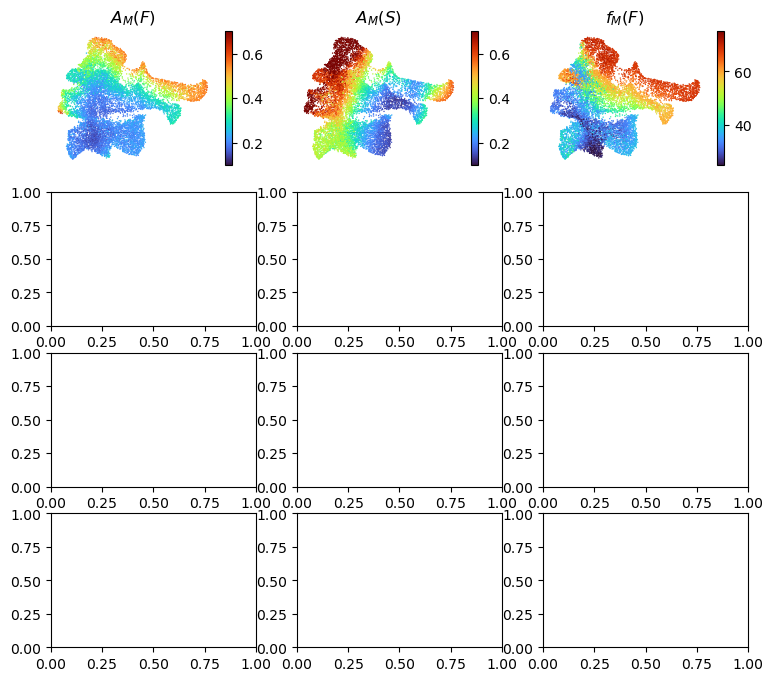

In [143]:
fig, axs = plt.subplots(4, 3, figsize=(9, 8))
for i in range(len(keys)//2):
    n = 2*i

    
        
    if n < 20:
        nr = n // 4
        nc = n 
    
    nr = n // 4
    nc = n - 4*nr
    


# Fequency change in each cluster

In [547]:
def _fft(detail):
    idt = detail["ts"] >= 0.5
    vlfp = detail["vlfp"][nt][idt]
    ts = detail["ts"][idt]
    fs = np.round(1/(ts[1] - ts[0]))

    # psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, ts, fs, mbin_t=0.1, wbin_t=1, frange=(3, 120))
    psd, fpsd = hhsignal.get_fft(vlfp, fs, nbin_t=2, frange=(3, 200))
    return psd, fpsd


psd_set, psd_base_set = [], []
for nc in range(len(clusters.id_set)):
    psd_tot = [0, 0, 0]
    for i in range(9):
        detail = summary_obj.load_detail(*repr_info["repr_idx"][nc], i)
        for nt in range(3):    
            psd, fpsd = _fft(detail)
            psd_tot[nt] += psd/9
    psd_set.append(psd_tot)

    # base
    psd_base = [0, 0, 0]    
    nechelon = repr_info["repr_idx"][nc][2]
    
    # for i in range(9):
    #     detail_base = sobj_base.load_detail(0, 0, nechelon, 0, i)
    #     for nt in range(3):
    #         psd_b, fpsd_b = _fft(detail_base)
    #         psd_base[nt] += psd_b/9
    # psd_base_set.append(psd_base)

IndexError: list index out of range

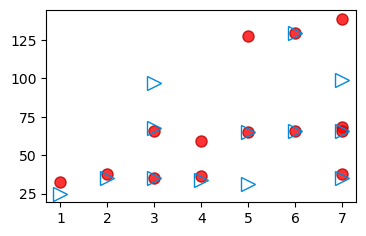

In [550]:
from scipy.signal import savgol_filter

plt.figure(figsize=(4, 2.5))

cset = ["k", "#b50202", "#008bdd"]
markers = ["", "o", ">"]

# fpeaks = [[] for _ in range(8)]
fpeaks_b = [[], [], []]

for nc in range(9):
    for nt in range(1, 3):
        yhat = savgol_filter(psd_set[nc][nt], 21, 1)
        npeaks = hhsignal.detect_peak(yhat, prominence=0.01, mode=0)
        
        # print("Cluster %d"%(nc+1))
        for n in npeaks:
            if nt == 1:
                plt.plot(nc+1, fpsd[n], markers[nt], color=cset[nt], markerfacecolor=[1, 0, 0, 0.8], markersize=8)
            if nt == 2:
                plt.plot(nc+1, fpsd[n], markers[nt], color=cset[nt], markerfacecolor="none", markersize=10)
            # print("%.3f"%(fpsd[n]))
            
        # yhat_b = savgol_filter(psd_base_set[nc][nt], 21, 1)
        # npeaks = hhsignal.detect_peak(yhat_b, prominence=0.02, mode=0)
        
        fpeaks_b[nt].append(fpsd[npeaks[0]])

fpeaks_b[1][-3] = fpeaks_b[1][-1]
fpeaks_b[2][-3] = fpeaks_b[2][-1]
        
plt.plot(np.arange(9)+1, fpeaks_b[1], '--', c=cset[1], alpha=0.4)
plt.plot(np.arange(9)+1, fpeaks_b[2], '--', c=cset[2], alpha=0.4)

plt.xticks(np.arange(1, 10))
plt.ylim([20, 75])

plt.xlabel("Cluster ID", fontsize=14)
plt.ylabel("peak frequency (Hz)", fontsize=14)

plt.show()

In [126]:
detail_data = summary_obj.load_detail(0, 0, 2, 10, 0)

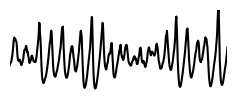

In [149]:
plt.figure(figsize=(2.8, 1.2))
plt.plot(detail_data["ts"], detail_data["vlfp"][1], color='k')
plt.xlim([1.9, 2.2])
plt.ylim([-67, -52])
plt.axis("off")
plt.show()

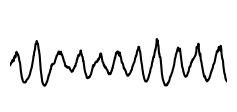

In [150]:
plt.figure(figsize=(2.8, 1.2))
plt.plot(detail_data["ts"], detail_data["vlfp"][2], color='k')
plt.xlim([1.2, 1.5])
plt.ylim([-67, -52])
plt.axis("off")
plt.show()

(1.2, 1.5)

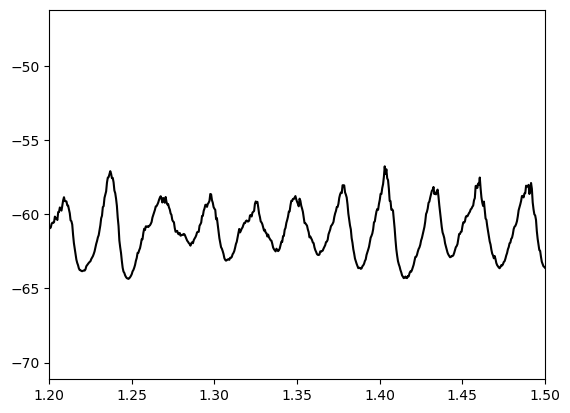

In [134]:
plt.figure()
plt.plot(detail_data["ts"], detail_data["vlfp"][2], color='k')
plt.xlim([1.2, 1.5])